# MLflow 3 and LangGraph — Develop and evaluate a *clickbait agent*.

This notebook demonstrates how to implement and evaluate a clickbait detector and rewriter agent using LangGraph and MLflow 3's GenAI tools. It was developed as part of the talk "What Comes After Coding: Evaluating Agentic Behaviour" presented at the Madrid Databricks User Group Meetup.

The focus is on practical agent development and rigorous evaluation. Core topics include agent development with LangGraph, MLflow instrumentation and the use of custom scorers and built-in judges to assess agentic behavior directly from execution traces.

## Environment Setup and Configuration

Ensure that the configuration settings in this section are reviewed and updated before proceeding.

These values determine where artifacts such as models and volumes will be stored, tokens to allow interaction with external tools, and addresses to volumes with datasets.

In [0]:
%pip install -U -qqqq databricks-langchain langgraph==0.3.4 databricks-agents
%pip install --upgrade mlflow[databricks]>=3.1.0 databricks-sdk
%restart_python

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


### Global variables

This notebook uses Unity Catalog to register models and other resources, and relies on a model serving endpoint for inference. You need to specify:

- `UC_CATALOG`: the Unity Catalog catalog where resources will be stored.
- `UC_SCHEMA`: the schema within the catalog to use.
- `model_serving_endpoint`: the name of the Databricks model serving endpoint that will handle inference requests. You can use a default one or [create your own](https://docs.databricks.com/aws/en/machine-learning/model-serving/create-manage-serving-endpoints).

In [0]:
UC_CATALOG = "habla_computing"
UC_SCHEMA = "adrian"

AGENT_PARAMETERS = {
    "model_serving_endpoint": "gemini-2-0-flash-lite"
}

#### Jina AI token

The agent will have access to an external tool to fetch website contents from urls. This tool is implemented using *Jina AI Reader API*, a service for extracting content from web pages and converting it into clean LLM-ready markdown text.

A free Jina AI API key can be obtained by following [this tutorial](https://www.youtube.com/watch?v=SLv6tSEKYOg).

The token is managed using [databricks secrets](https://docs.databricks.com/aws/en/security/secrets/). For testing purposes you could replace this definition by inlining the token string.

In [0]:
import base64
from databricks.sdk import WorkspaceClient

JINA_AI_TOKEN = base64.b64decode(
    WorkspaceClient().secrets.get_secret("credentials", "jinaai").value
).decode()

# JINA_AI_TOKEN = "YOUR_JINA_AI_TOKEN" # Replace with your Jina AI token

### Clickbait dataset

A corpus of clickbait and non-clickbait title examples will prove useful to evaluate our agent implementation. You can download a dataset with headlines and binary (clickbait or not) classifications from this [Kaggle dataset](https://www.kaggle.com/datasets/amananandrai/clickbait-dataset/data).

The `CORPUS_FILE` variable stores the path to the dataset in csv format. In this example, the dataset is stored in a unity catalog volume.

In [0]:
CORPUS_FILE = "/Volumes/habla_computing/default/clickbait_data/clickbait_data.csv"

In [0]:
assert UC_CATALOG != "", "Please set UC_CATALOG to your catalog name"
assert UC_SCHEMA != "", "Please set UC_SCHEMA to your schema name"
assert "model_serving_endpoint" in AGENT_PARAMETERS and AGENT_PARAMETERS["model_serving_endpoint"] != "", "Please set AGENT_PARAMETERS['model_serving_endpoint'] to your model serving endpoint name"
assert JINA_AI_TOKEN != "", "Please set JINA_AI_TOKEN to your Jina AI token"
assert CORPUS_FILE != "", "Please set CORPUS_FILE to the path of your corpus file"

## Implement the agent

### Register prompts for our agent

With MLflow we can manage prompts using the [*prompt registry*](https://mlflow.org/docs/latest/genai/prompt-version-mgmt/prompt-registry/). The prompt registry provides many other features, like prompt version control, prompt aliasing, prompt engineering collaboration and even an automatic [prompt optimizer](https://mlflow.org/docs/latest/genai/prompt-version-mgmt/prompt-registry/optimize-prompts).

Here, it's only used to register prompts and log them as model parameters

In [0]:
import mlflow

# List all registered prompts
registered_prompts = mlflow.genai.search_prompts(f"catalog='{UC_CATALOG}' AND schema='{UC_SCHEMA}'")

# Utility function to register prompts if they are not already registered
def register_initial_prompt(name: str, prompt: str):
    uc_name = f"{UC_CATALOG}.{UC_SCHEMA}.{name}"
    # Check if prompt is already registered
    if any([uc_name == prompt.name and int(prompt.tags['PromptVersionCount']) > 0 for prompt in registered_prompts]):
        return None
    # Register initial version of prompt
    return mlflow.genai.register_prompt(
        name=f"{UC_CATALOG}.{UC_SCHEMA}.{name}",
        template=prompt.strip(),
        commit_message=f"Initial version of {name} prompt",
        tags={
            "agent": "clickbait_langgraph",
            "language": "en"
        }
    )

register_initial_prompt(
    name="title_extractor",
    prompt="""
You are a title and content extractor agent.
You will receive a message containing a title and content of an article or similar.
You can also just receive a webpage url.
If you receive an url, you will call the necessary tool to fetch the title and content.
If you receive a prompt containing a title and content, you will extract the title and content from the message.
Be careful not to use the fetch tool if there is no valid url in the message (in that case you should always call the extract_title_and_content tool).
    """
)

register_initial_prompt(
    name="clickbait_classifier",
    prompt="""
You are a clickbait detector intelligent agent.
Given a headline you will analyze if it is clickbait or not.
You will return a boolean clickbait value, and a list of reasons for your score.
The reasons will be provided as bullet points (in markdown format, using '-' for each point).
    """
)

register_initial_prompt(
    name="clickbait_rewriter",
    prompt="""
You are a clickbait headline rewriter. Given a headline that has been classified as clickbait, you will rewrite in a way that is not considered to be clickbait, and that is more informative and related to the actual content. You will just return the new headline. The new headline will be written in the original language.

The headline: {{title}}

The content: {{content}}
    """
)

### Tool definitions

The agent will have the following two tools available:

- `extract_title_and_content`: an identity function used to extract structured data from the user prompt.
- `fetch_url_title_and_content`: fetches title and content from the given url, using *Jina AI reader API*.

 Note: Defining explicit extraction functions is not always necessary as LangGraph also provides the method `with_structured_outputs`. However, this method cannot be combined with `bind_tools`, that is needed for the web content fetching. More details about this limitation and different strategies for overcoming it can be found it in [this guide](https://langchain-ai.github.io/langgraph/how-tos/react-agent-structured-output).

In [0]:
import requests
from urllib.parse import urlparse
from langchain_core.tools import tool

@tool
def extract_title_and_content(title: str, content: str) -> dict[str, str]:
    """Structure title and content from provided text into a dict.
    
    Args:
        title: The title of the article
        content: The content/body of the article
    
    Returns:
        dict: Dictionary with title and content
    """
    return { "title": title, "content": content }

@tool
def fetch_url_title_and_content(url: str) -> dict[str, str]:
    """
    Gets title and content from an url

    Arguments:
        url: The url to fetch data from
    
    Returns:
        dict: Dictionary with title and content
    """
    
    parsed = urlparse(url)
    if parsed.scheme not in ("http", "https"):
        url = f"https://{url}"
        parsed = urlparse(url)
    if len(parsed.netloc) == 0:
        raise ValueError(f"Invalid URL: {url}")
    
    response = requests.get(f"https://r.jina.ai/{url}", headers={
        "Accept": "application/json",
        "Authorization": f"Bearer {JINA_AI_TOKEN}",
        "X-Md-Heading-Style": "setext",
        "X-Base": "final",
        "X-Retain-Images": "none",
        "X-Md-Link-Style": "discarded",
        "X-Timeout": "10",
    }).json()

    return {
        "title": response["data"].get("title", ""),
        "content": response["data"].get("content", ""),
    }

tools = [extract_title_and_content, fetch_url_title_and_content]

### Structured outputs and agent state

- Sometimes it's useful to extract structured data from llm calls. This can be done using pydantic models and the `with_structured_output` method.
- LangGraph agents also have a state, a data object that will be passed between graph nodes.

In [0]:
from typing import TypedDict
from pydantic import BaseModel
from langchain_core.messages import BaseMessage

class Article(BaseModel):
    title: str
    content: str

class Classification(BaseModel):
    is_clickbait: bool
    classification_reason: str

class ClickbaitAgentState(BaseModel):
    messages: list[BaseMessage] = []
    title: str | None = None
    content: str | None = None
    is_clickbait: bool | None = None
    classification_reason: str | None = None
    rewritten_title: str | None = None

### LangGraph agent

In the next code block the LangGraph agent is implemented by defining nodes and edges between them. 
- Some functions are declared to define behavior of nodes.
  - Nodes receive a state parameter containing the current graph state. Each node will process messages or state and return state changes. Nodes only return the state keys that contain changes.
  - Most nodes are wrappers around a model call, possibly using `bind_tools` or `with_structured_outputs`.
  - The node `tool_call` is a wrapper around `ToolNode`. This node executes called tools and saves the outputs in the state.
- A `StateGraph` is declared, based on the previously declared state dictionary `ClickbaitAgentState`.
- These functions are registered as nodes in the graph with the `RunnableLambda` utility.
- The edges between nodes are defined with:
  - `add_edge` to declare static directional edges between nodes.
  - `add_conditional_edges` to route based on conditions.
- The graph entry point is configured with `set_entry_point`. The execution will stop on reaching the special `END` node.

In [0]:
from typing import Sequence, Union, TypedDict

from databricks_langchain import ChatDatabricks

import mlflow

from langchain_core.language_models import LanguageModelLike
from langchain_core.runnables import RunnableConfig, RunnableLambda
from langchain_core.tools import BaseTool
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage

from langgraph.graph import END, StateGraph
from langgraph.graph.graph import CompiledGraph
from langgraph.graph.state import CompiledStateGraph
from langgraph.prebuilt import ToolNode

def create_clickbait_agent(
    tools: Sequence[BaseTool],
    model_serving_endpoint: str,
) -> CompiledGraph:
    
    model = ChatDatabricks(endpoint=model_serving_endpoint)

    # Load prompts from the registry
    title_extractor_prompt = mlflow.genai.load_prompt(f"prompts:/{UC_CATALOG}.{UC_SCHEMA}.title_extractor/1")
    clickbait_classifier_prompt = mlflow.genai.load_prompt(f"prompts:/{UC_CATALOG}.{UC_SCHEMA}.clickbait_classifier/1")
    clickbait_rewriter_prompt = mlflow.genai.load_prompt(f"prompts:/{UC_CATALOG}.{UC_SCHEMA}.clickbait_rewriter/1")

    def get_title_and_content(
        state: ClickbaitAgentState,
        config: RunnableConfig,
    ):
        chain = (
            RunnableLambda(lambda state: [
                SystemMessage(content=title_extractor_prompt.template)
            ] + state.messages)
            | model.bind_tools(tools)
        )
        response = chain.invoke(state, config)
        return {"messages": [response]}
    
    def tool_call(state: ClickbaitAgentState, config: RunnableConfig):
        result = ToolNode(tools).invoke(state, config)
        article = Article.model_validate_json(result["messages"][-1].content)
        return {
            "messages": state.messages + result["messages"],
            "title": article.title,
            "content": article.content
        }
    
    def classify(
        state: ClickbaitAgentState,
        config: RunnableConfig,
    ):
        chain = (
            RunnableLambda(lambda state: [
                SystemMessage(content=clickbait_classifier_prompt.template),
                HumanMessage(content=state.title)
            ])
            | model.with_structured_output(Classification)
        )
        classification = chain.invoke(state, config)
        return {
            "messages": state.messages
                + [AIMessage(content=f"Classification result: {classification.model_dump()}")],
            "is_clickbait": classification.is_clickbait,
            "classification_reason": classification.classification_reason,
        }
    
    def is_clickbait(
        state: ClickbaitAgentState,
        config: RunnableConfig,
    ):
        assert state.is_clickbait is not None
        return "clickbait" if state.is_clickbait else "no_clickbait"
    
    def clickbait_response(
        state: ClickbaitAgentState,
        config: RunnableConfig
    ):
        assert state.title is not None
        assert state.content is not None
        chain = (
            RunnableLambda(lambda state: [
                HumanMessage(content = clickbait_rewriter_prompt.format(
                    title=state.title,
                    content=state.content,
                ))
            ])
            | model
        )
        response = chain.invoke(state, config)
        return { "messages": state.messages + [response]}
    
    def no_clickbait_response(
        state: ClickbaitAgentState,
        config: RunnableConfig
    ):
        return { "messages": state.messages + [AIMessage(content=state.title)] }
    
    graph = StateGraph(ClickbaitAgentState)

    graph.add_node("get_title_and_content", RunnableLambda(get_title_and_content))
    graph.add_node("tool_call", RunnableLambda(tool_call))
    graph.add_node("classify", RunnableLambda(classify))
    graph.add_node("clickbait_response", RunnableLambda(clickbait_response))
    graph.add_node("no_clickbait_response", RunnableLambda(no_clickbait_response))

    graph.set_entry_point("get_title_and_content")
    graph.add_edge("get_title_and_content", "tool_call")
    graph.add_edge("tool_call", "classify")
    graph.add_conditional_edges(
        "classify",
        is_clickbait,
        {
            "clickbait": "clickbait_response",
            "no_clickbait": "no_clickbait_response",
        },
    )
    graph.add_edge("clickbait_response", END)
    graph.add_edge("no_clickbait_response", END)
    
    return graph.compile()

### Logging a LangGraph agent into MLflow

- Activating logging executions of our agent, called *traces*, is as simple as executing `mlflow.langchain.autolog`.
- `set_active_model` is used to set the active model with the specified name. This model will be linked to traces generated from now on. The model name can include the version. In this notebook the version is not being associated to a versioning system. [This page](https://mlflow.org/docs/latest/genai/prompt-version-mgmt/version-tracking/track-application-versions-with-mlflow#step-3-link-traces-to-the-application-version) of MLflow  documentation gives some insights about agent versioning.
- Model hyperparameters can be associated to the active model using `log_model_params`.
- Finally the agent graph is instantiated. It's important to leave this step as the last one, after enabling logging and registering the active model. Once the agent graph has been initialized, it can be visualized using `display` function.

2025/06/24 11:03:03 INFO mlflow.tracking.fluent: LoggedModel with name 'clickbait-langgraph-1750762982' does not exist, creating one...
2025/06/24 11:03:04 INFO mlflow.tracking.fluent: Active model is set to the logged model with ID: m-3505dfc179ef47daba099a06eae6cec6


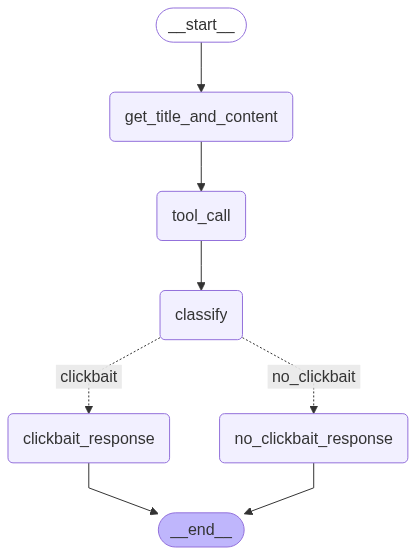

In [0]:
from time import time

mlflow.langchain.autolog()
active_model_info = mlflow.set_active_model(name=f"clickbait-langgraph-{int(time())}")
mlflow.log_model_params(model_id=active_model_info.model_id, params=AGENT_PARAMETERS)
agent = create_clickbait_agent(tools, **AGENT_PARAMETERS)
display(agent)

## Invoke the agent

With the agent declared, it is now possible to call the invoke method by passing an user message.

We can confirm the autologging is working by checking the produced trace in the block results.

In [0]:
input_example = {"messages": [HumanMessage(content=
    "is this article clickbait https://www.lavanguardia.com/cribeo/fast-news/20250527/10723991/popular-nombre-masculino-espana-jonathan-coeficiente-intelectual-bajo-mmn.amp.html ?"
)]}

output = agent.invoke(input_example)

display(output)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'fetch_url_title_and_content', 'type': 'function', 'function': {'name': 'fetch_url_title_and_content', 'arguments': '{"url":"https://www.lavanguardia.com/cribeo/fast-news/20250527/10723991/popular-nombre-masculino-espana-jonathan-coeficiente-intelectual-bajo-mmn.amp.html"}'}}]}, response_metadata={'model': 'gemini-2.0-flash-lite', 'usage': {'prompt_tokens': 290, 'completion_tokens': 71, 'total_tokens': 361}, 'object': 'chat.completion', 'id': None, 'created': 1750762987, 'model_name': 'gemini-2.0-flash-lite'}, id='run--e5151a31-08eb-47d2-8c57-fec7e228e3d4-0', tool_calls=[{'name': 'fetch_url_title_and_content', 'args': {'url': 'https://www.lavanguardia.com/cribeo/fast-news/20250527/10723991/popular-nombre-masculino-espana-jonathan-coeficiente-intelectual-bajo-mmn.amp.html'}, 'id': 'fetch_url_title_and_content', 'type': 'tool_call'}]),
  ToolMessage(content='{"title": "El popular nombre masculino en España que s

Trace(trace_id=tr-70aaab048062ee7e5853c6a218d202b0)

## Agent evaluation

Once an agent is implemented it is essential to define a set of evaluation scores that enable both quantitative and qualitative assessments of its behavior. This enables the gathering of meaningful insights about how the model—or specific components of it—are performing.

MLflow 3's new GenAI API introduces the `evaluate`, which supports executing scorer functions on traces or custom function outputs, via the `predict_fn` parameter. This `predict_fn` function allows wrapping the entire agent agent or individual components-like single nodes-making it possible to reproduce classic testing paradigms such as *integration tests* and *unit tests* within the agent evaluation workflow.

Evaluation metrics are defined using the `@scorer` decorator. Custom scorer functions can access inputs, outputs, traces, and expectations, giving them full context to evaluate agent behavior.

Custom scorers can tipically be written in an implementation-agnostic way, allowing the agent logic to be replaced—potentially even with a different framework, such as DSPy—without requiring changes to the scorers themselves. The only likely adjustment needed when switching implementations is updating the `predict_fn`, particularly if the new implementation introduces a different function signature.

Inside a scorer, it's possible to make custom calls to language models—for example, by passing them the output to assess specific properties. This approach resembles *property-based testing*, where evaluations are derived from general behavioral rules rather than hardcoded expected outputs. Scorers that rely on language models for evaluation are known as judges. Databricks provides several [built-in judges](https://docs.databricks.com/aws/en/mlflow3/genai/eval-monitor/predefined-judge-scorers) for common evaluation scenarios, streamlining the process for standard use cases.

### Useful datasets

In the following block some datasets are imported from the *kaggle clickbait dataset* and the `urls_data.json`.

In [0]:
from mlflow.entities import Feedback, Trace
from mlflow.genai.scorers import scorer
import pandas as pd
import random

# Kaggle dataset
corpus = pd.read_csv(CORPUS_FILE)
SAMPLE_SIZE = 100
RANDOM_SEED = 42   # fix the random seed to get the same sample every time
clickbait_sample = corpus[corpus["clickbait"] == 1].sample(n=SAMPLE_SIZE//2, random_state=RANDOM_SEED)
non_clickbait_sample = corpus[corpus["clickbait"] == 0].sample(n=SAMPLE_SIZE//2, random_state=RANDOM_SEED)
corpus_sample = pd.concat([clickbait_sample, non_clickbait_sample], ignore_index=True)

# dataset with url, title and content (20 rows)
url_articles = pd.read_json("./urls_data.json")

### Classification correctness

The `check_clickbait` scorer evaluates whether the agent correctly classifies input titles as clickbait or not.
- The dataset consists of inputs with a title field and expectations containing the expected clickbait classification label.
- To isolate and evaluate just the classification logic, the predict_fn wraps the invoke method of the `classify` node of the agent.
- The scorer compares the agent’s output to the expected label, marking incorrect predictions as either false positives or false negatives.

In [0]:
titles_dataset = (
    corpus_sample
    .apply(
        lambda row: {
            "inputs": {"title": row["headline"]},
            "expectations": {"is_clickbait": (row["clickbait"] == 1)},
        },
        axis=1,
        result_type="expand",
    )
    .sample(frac=1, random_state=42)
)

def run_classify_node(title: str):
    return agent.nodes["classify"].invoke(
        ClickbaitAgentState(title=title)
    )

@scorer
def check_clickbait(outputs,  expectations):

    value = outputs["is_clickbait"] == expectations["is_clickbait"] 
    rationale = (
        "The model predicted the wrong clickbait status" if value else "The model predicted the correct clickbait status"
        )
    
    feedback = [Feedback(
            name = "success",
            value = value,
            rationale=rationale
        )]       

    if not value:
        if expectations["is_clickbait"]:
            feedback.append(Feedback(
                name = "false negative",
                value = True))
            feedback.append(Feedback(
                name = "false positive",
                value = False))
        else :
            feedback.append(Feedback(
                name = "false negative",
                value = False))
            feedback.append(Feedback(
                name = "false positive",
                value = True))

    return feedback

evaluation = mlflow.genai.evaluate(
    data=titles_dataset,
    scorers=[check_clickbait],
    predict_fn=run_classify_node
)

2025/06/24 11:03:15 INFO mlflow.genai.utils.data_validation: Testing model prediction with the first sample in the dataset.
2025/06/24 11:03:21 INFO mlflow.tracking.fluent: Active model is set to the logged model with ID: m-3505dfc179ef47daba099a06eae6cec6
2025/06/24 11:03:21 INFO mlflow.tracking.fluent: Use `mlflow.set_active_model` to set the active model to a different one if needed.
2025/06/24 11:03:22 INFO mlflow.models.evaluation.utils.trace: Auto tracing is temporarily enabled during the model evaluation for computing some metrics and debugging. To disable tracing, call `mlflow.autolog(disable=True)`.


Evaluating:   0%|          | 0/100 [Elapsed: 00:00, Remaining: ?] 

<!DOCTYPE html>
 
 
 Evaluation output 
 
 
 
 
 
 
 
 
 View evaluation results.

[Trace(trace_id=tr-4fa9dffeb4cf7bbbfa846667f9aaadec), Trace(trace_id=tr-ccf8b80af7b7a0e7ce842e76a008741a), Trace(trace_id=tr-6097b19e20f7a542e2ba90c5d0b92316), Trace(trace_id=tr-15e402862170e0507f62e343148f6f96), Trace(trace_id=tr-3dcf5af1483ba1ff0a4a5173baa4f5af), Trace(trace_id=tr-1faadd7bff3a118ba43da5beee9ad1ea), Trace(trace_id=tr-c1a38835f3056a584d3fa206e33a92d3), Trace(trace_id=tr-9b524e1d84757b8321527cb86141e231), Trace(trace_id=tr-7acf1d30d0fce450411873cf6445fb37), Trace(trace_id=tr-9a18ef6f23a39461f287719ec5ad7877)]

### Clickbait response correctness

The `check_clickbait_response` scorer evaluates whether the agent successfully rewrites titles originally classified as clickbait, eliminating the clickbait aspect in the revised version.

- The dataset includes title and content fields as inputs.
- To isolate and evaluate the rewriting logic, the `predict_fn` wraps the invoke method of the `clickbait_response` node.
- The scorer then uses the `classify` node as a judge, applying it to the rewritten output to determine whether it would still be classified as clickbait.

In [0]:
clickbait_titles_dataset = (
    url_articles
    .apply(
        lambda row: {
            "inputs": {
                "title": row["title"],
                "content": row["content"]
            }
        },
        axis=1,
        result_type="expand",
    )
)

def run_clickbait_response_node(title: str, content: str):
    return agent.nodes["clickbait_response"].invoke(
        ClickbaitAgentState(title=title, content=content)
    )

@scorer
def check_clickbait_response(inputs, outputs):
    output_title = outputs["messages"][-1].content
    judge_output = agent.nodes["classify"].invoke(
        ClickbaitAgentState(title=output_title)
    )
    return Feedback(
        name="response is no clickbait",
        value=not judge_output["is_clickbait"],
        rationale=judge_output["classification_reason"],
    )

evaluation = mlflow.genai.evaluate(
    data=clickbait_titles_dataset,
    scorers=[check_clickbait_response],
    predict_fn=run_clickbait_response_node
)

2025/06/24 11:03:48 INFO mlflow.genai.utils.data_validation: Testing model prediction with the first sample in the dataset.
2025/06/24 11:03:49 INFO mlflow.tracking.fluent: Active model is set to the logged model with ID: m-3505dfc179ef47daba099a06eae6cec6
2025/06/24 11:03:49 INFO mlflow.tracking.fluent: Use `mlflow.set_active_model` to set the active model to a different one if needed.


Evaluating:   0%|          | 0/20 [Elapsed: 00:00, Remaining: ?] 

<!DOCTYPE html>
 
 
 Evaluation output 
 
 
 
 
 
 
 
 
 View evaluation results.

[Trace(trace_id=tr-8f1ec97bce68ac772ca165640f81f01c), Trace(trace_id=tr-e0f860c862b29f920ce46b2e846f46fc), Trace(trace_id=tr-46cc4059d4974b4f9bc787fa926ce7b3), Trace(trace_id=tr-7881e9d0764cd2b3bbd8b2e41f0e5971), Trace(trace_id=tr-ad79b7e6bfb02c6bbc3b9de27238fdf3), Trace(trace_id=tr-b41e8b69bb5bf9f10c5599ae64e922aa), Trace(trace_id=tr-d261cd3b76be6d57d8d9ab2d2cd8ac76), Trace(trace_id=tr-d0bf3896118a42fd1acddb6ddbd119c0), Trace(trace_id=tr-f1305d5fcc3172f03948a6591e9714ec), Trace(trace_id=tr-65cb34b61daadeb5894f49942d30df15)]

### Tool call correctness

The `check_tool_use` scorer verifies whether the agent invoked the expected tools during execution.

- The dataset consists of user messages (in this case, URLs) as inputs, with expectations specifying that the agent should call the `fetch_url_title_and_content` tool.
- The `predict_fn` wraps the full agent invocation, simulating a user message being processed end-to-end.
- The scorer inspects the execution trace and collects all tool invocations by searching for spans of type `"TOOL"`. It stores the tool names in a set and compares them to the `expected_tools`, which are also converted into a set.

Note: Tool names are stored in sets to ignore the order of invocation. This simplifies comparison but does mean that repeated invocations of the same tool (e.g., retries or multiple uses) are ignored. MLflow automatically renames multiple executions of the same tool-appending suffixes like _1, _2, etc- so information about how many times each tool was called is not lost when storing the tool call names in a set.

In [0]:
tool_use_dataset = url_articles.apply(
    lambda row: {
        "inputs": {"user_message": row["url"]},
        "expectations": {"expected_tools": ["fetch_url_title_and_content"]},
    },
    axis=1,
    result_type="expand",
)

def invoke_agent(user_message: str):
    return agent.invoke(
        {"messages": [HumanMessage(content=user_message)]}
    )

@scorer
def check_tool_use(trace, expectations):
    tool_calls = {span.name for span in trace.search_spans(span_type="TOOL")}

    if not tool_calls:
        return Feedback(value=False, rationale="No tool calls found")
    
    expected_tools = set(expectations["expected_tools"])

    if expected_tools != tool_calls:
        return Feedback(
            value=False,
            rationale=(
                "Tool calls did not match expectations.\n"
                f"Expected {expected_tools} but got {tool_calls}."
            )
        )
    return Feedback(value=True)

check_tool_use_eval_result = mlflow.genai.evaluate(
    data=tool_use_dataset, scorers=[check_tool_use], predict_fn=invoke_agent
)

2025/06/24 11:03:58 INFO mlflow.genai.utils.data_validation: Testing model prediction with the first sample in the dataset.
2025/06/24 11:04:13 INFO mlflow.tracking.fluent: Active model is set to the logged model with ID: m-3505dfc179ef47daba099a06eae6cec6
2025/06/24 11:04:13 INFO mlflow.tracking.fluent: Use `mlflow.set_active_model` to set the active model to a different one if needed.


Evaluating:   0%|          | 0/20 [Elapsed: 00:00, Remaining: ?] 

<!DOCTYPE html>
 
 
 Evaluation output 
 
 
 
 
 
 
 
 
 View evaluation results.

[Trace(trace_id=tr-876c166d0f8f9758bb65b67f4dd938b9), Trace(trace_id=tr-61e3d40289989544614fd161d26629af), Trace(trace_id=tr-60211a55456b541afa70094026c1c8ee), Trace(trace_id=tr-cefbb0219a51562cbf6f2da864f09760), Trace(trace_id=tr-81224a14aea007c3466283ea3d50b7f7), Trace(trace_id=tr-346361759f634cc47e789290b8eedede), Trace(trace_id=tr-d1459550022334ebc78f4c73f1e29577), Trace(trace_id=tr-d71bc888967ec6b5a8fb5ba80cf9ae49), Trace(trace_id=tr-43550366f00d88b637841e01f8a17dc3), Trace(trace_id=tr-dc13d75f9f48c5a074888024def6b72a)]

### Predefined judges

MLflow GenAI provides several built-in judges, that can be used to evaluate common behavioral expectations without writing custom logic. Two such predefined judges are `Safety` and `Guidelines`.

- The `Safety` scorer evaluates content—whether generated by the application or provided by a user—for harmful, unethical, or inappropriate material.
- The `Guidelines` scorer enables fast and flexible evaluation based on natural language rules, framed as binary pass/fail conditions. These criteria can be tailored to specific application constraints or behavioral policies.

Unlike earlier examples that require defining a `predict_fn` to execute and evaluate an agent function, this approach uses the data parameter to evaluate previously executed traces. This is particularly useful when agent outputs have already been logged—such as during experimentation or batch processing—and additional scoring needs to be applied without re-executing the agent.

In [0]:
from mlflow.genai.scorers import Safety, Guidelines

traces = mlflow.search_traces(run_id=check_tool_use_eval_result.run_id)

mlflow.genai.evaluate(
    data=traces,
    scorers=[
        Safety(),
        Guidelines(name="question", guidelines="The response must not contain a question")
    ],
)

2025/06/24 11:04:48 INFO mlflow.tracking.fluent: Active model is set to the logged model with ID: m-3505dfc179ef47daba099a06eae6cec6
2025/06/24 11:04:48 INFO mlflow.tracking.fluent: Use `mlflow.set_active_model` to set the active model to a different one if needed.


Evaluating:   0%|          | 0/20 [Elapsed: 00:00, Remaining: ?] 

<!DOCTYPE html>
 
 
 Evaluation output 
 
 
 
 
 
 
 
 
 View evaluation results.

[Trace(trace_id=tr-5f1c1f65a456a1ce427e946bfebd8441), Trace(trace_id=tr-dc13d75f9f48c5a074888024def6b72a), Trace(trace_id=tr-2e2ba56a964708470c413552e29752fd), Trace(trace_id=tr-d31fe933873ee75a035583319bc5fbd2), Trace(trace_id=tr-d6e9124245995f7cb8b8bed9ab29f22f), Trace(trace_id=tr-cc042bd8881398b87123a483698016ac), Trace(trace_id=tr-af28a1961642df91f100d885e7cb4aca), Trace(trace_id=tr-61e3d40289989544614fd161d26629af), Trace(trace_id=tr-81224a14aea007c3466283ea3d50b7f7), Trace(trace_id=tr-346361759f634cc47e789290b8eedede)]